In [1]:
# === 0. 需要的套件 ======================================================
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import sys, itertools, warnings
warnings.filterwarnings("ignore")

TAIL_L  = 5                                # 你實驗允許的最長補丁 token 數
ROOT    = Path("results_top1")                 # <<<<<< 這裡改成你的資料夾 >>>>>>

# === 1. 讀進所有 records.csv ===========================================
csv_files = list(ROOT.glob("records.csv"))
if not csv_files:
    sys.exit(f"❌ 在 {ROOT} 找不到 records.csv")

df = pd.concat([pd.read_csv(f).assign(topK=f.parent.stem)
                for f in csv_files], ignore_index=True)

# 數值欄位保險起見轉一下型別 -----------------
df["token_used"] = df["token_used"].astype(int)
df["success"]    = df["success"].astype(int)
print(df.groupby("method").success.agg(['sum','count']))

print(df[(df.method=="greedy") & (df.success==1)].head())
# 以一筆失敗範例確認
sample = df.iloc[0]



SystemExit: ❌ 在 results_top1 找不到 records.csv

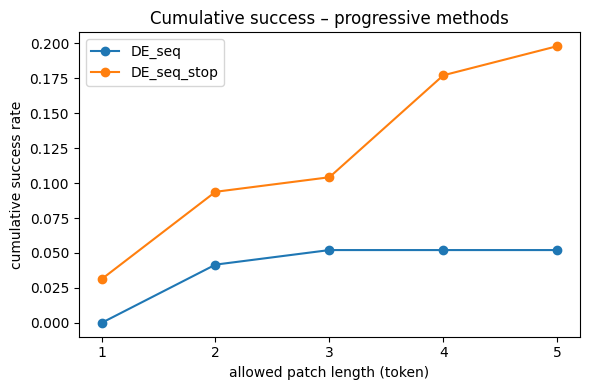

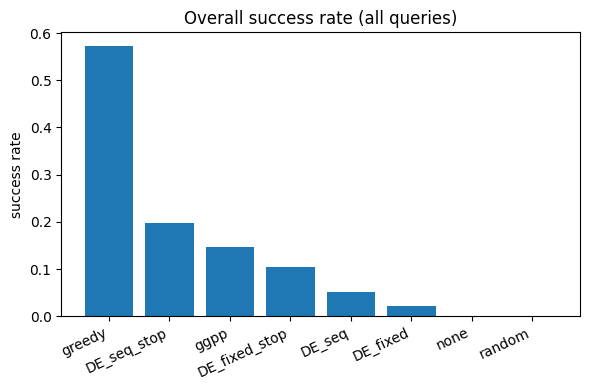

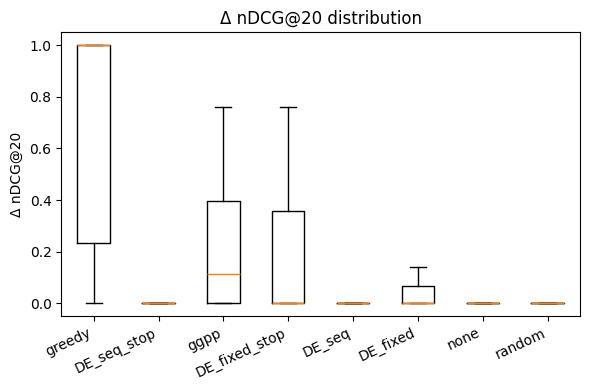

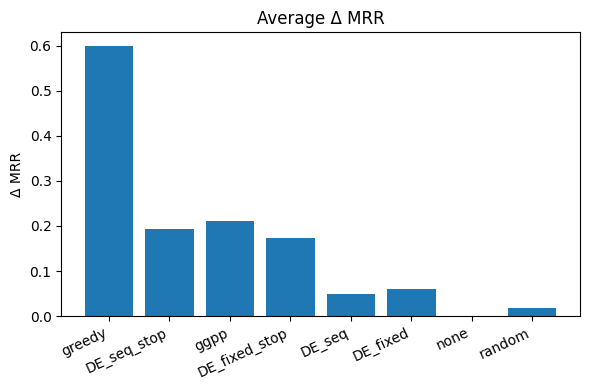

In [15]:
# === 2. 累進成功率（只對「逐步加 token」方法）============================
seq_methods = {"DE_seq", "DE_seq_stop"}       # 如有更多序列式攻擊加進來

# 演算法：對每種 method、每個 L=1..TAIL_L
#   計算「在此長度預算內已經成功」( success==1 且 token_used<=L ) 的比例
cum_rows = []
for m in seq_methods:
    sub = df[df.method == m]
    for L in range(1, TAIL_L + 1):
        win_rate = ((sub["success"] == 1) & (sub["token_used"] <= L)).mean()
        cum_rows.append({"method": m, "L": L, "rate": win_rate})
cum = pd.DataFrame(cum_rows)

plt.figure(figsize=(6,4))
for m, g in cum.groupby("method"):
    plt.plot(g.L, g.rate, marker="o", label=m)
plt.xticks(range(1, TAIL_L+1))
plt.xlabel("allowed patch length (token)")
plt.ylabel("cumulative success rate")
plt.title("Cumulative success – progressive methods")
plt.legend()
plt.tight_layout()
plt.show()

# === 3. 各方法總成功率長條圖 ============================================
succ = (df.groupby("method")["success"]
          .mean()
          .sort_values(ascending=False))

plt.figure(figsize=(6,4))
plt.bar(succ.index, succ.values)
plt.ylabel("success rate")
plt.title("Overall success rate (all queries)")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

# === 4. Δ nDCG@20 盒鬚圖（去掉 1% 極端值）==============================
low, high = df.delta_ndcg.quantile([.01, .99])
ndcg_clip = df[df.delta_ndcg.between(low, high)]

method_order = succ.index            # 跟成功率同順序
plt.figure(figsize=(6,4))
plt.boxplot([ndcg_clip[ndcg_clip.method==m].delta_ndcg
             for m in method_order],
            labels=method_order,
            showfliers=False)
plt.ylabel("Δ nDCG@20")
plt.title("Δ nDCG@20 distribution")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

# === 5. 平均 Δ MRR 長條圖 ==============================================
mrr = df.groupby("method")["delta_mrr"].mean().loc[method_order]

plt.figure(figsize=(6,4))
plt.bar(mrr.index, mrr.values)
plt.ylabel("Δ MRR")
plt.title("Average Δ MRR")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

有效 query 數 = 96  (其餘被長度>510 篩掉)

=== success-only statistics ===
               success_cnt  succ_rate  avg_token  avg_iter  avg_dMRR  \
method                                                                 
DE_fixed                 2        1.0      5.000   800.000     0.993   
DE_fixed_stop           10        1.0      5.000  2110.000     0.971   
DE_seq                   5        1.0      2.200   576.000     0.936   
DE_seq_stop             19        1.0      2.947  4949.474     0.976   
ggpp                    14        1.0      5.000     3.143     0.977   
greedy                  55        1.0      5.000     2.491     0.990   

               avg_dNDCG  avg_dcos  
method                              
DE_fixed           1.000     0.096  
DE_fixed_stop      0.937     0.031  
DE_seq             0.865     0.042  
DE_seq_stop        0.952     0.009  
ggpp               0.955     0.055  
greedy             0.983    -0.008  


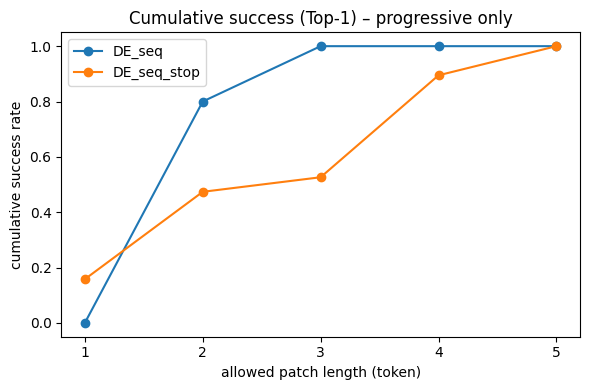

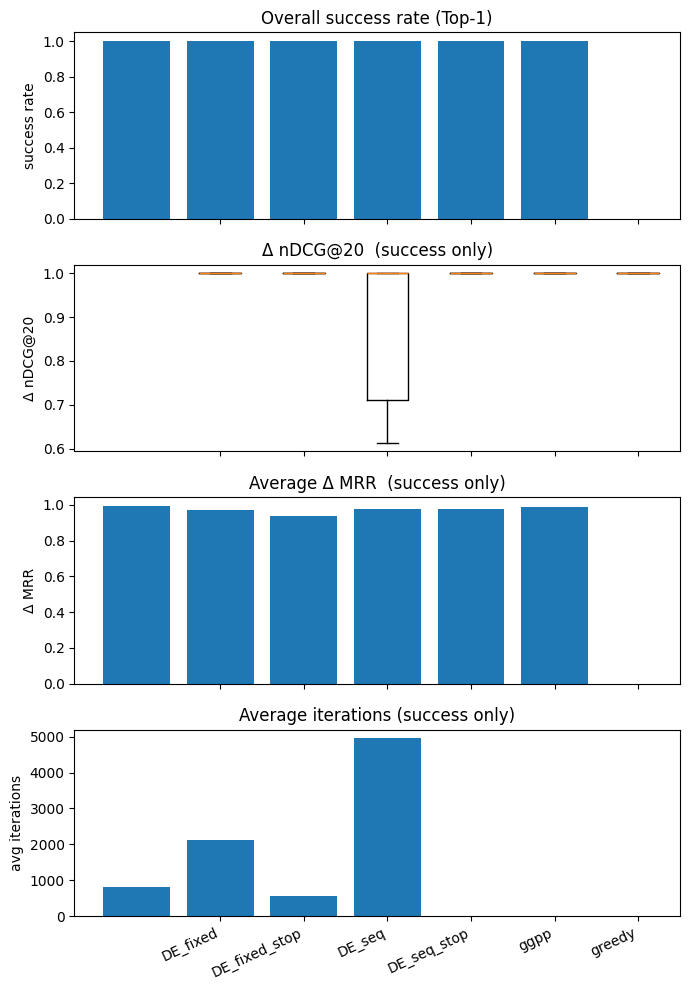

In [32]:
# ============================================================
#  Tail-Patch eval (Top-1) – fair statistics & plots
#  author : <you>
# ============================================================
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from pathlib import Path

# ------------ 基本參數 -----------------------
ROOT      = Path("results_top1/records.csv")   # ← log 檔
TOPK      = 1
TAIL_L    = 5
SEQ_METHODS = {"DE_seq", "DE_seq_stop"}

# ------------ 讀取並補上 qid -----------------
df = pd.read_csv(ROOT)

# ❶  為何只有 96 queries？
n_query = df.groupby(['method']).size().min()
print(f"有效 query 數 = {n_query}  (其餘被長度>510 篩掉)")

# 加入 qid（同一 query 依序寫 8 行）
df["qid"] = np.repeat(range(n_query), len(df)//n_query)

# ------------ 2. progressive – 取「第一次成功」 ----------
first_hit = []
for m in SEQ_METHODS:
    sub = df[df.method == m]
    # 依 qid & token_used 由小到大；找到第一筆 success==1
    f = (sub[sub.success == 1]
         .sort_values(["qid", "token_used"])
         .groupby("qid").first())      # 只留第一筆
    first_hit.append(f)

# 把過濾後的結果 (success==1) 合併回 df 供後續統計
mask = pd.concat(first_hit).index
df_prog = df.set_index(["qid","method","token_used"])
df_prog.loc[mask, "keep"] = True
df.loc[df_prog["keep"].fillna(False).values, "keep"] = True
df = df[(~df.method.isin(SEQ_METHODS)) | df.keep]

# ------------ 3. 統計表 (只對 success==1) ------------
succ_only = df[df.success == 1]

stats = (succ_only
         .groupby("method")
         .agg(success_cnt = ("success","sum"),
              succ_rate   = ("success","mean"),          # ÷96
              avg_token   = ("token_used","mean"),
              avg_iter    = ("iter_used","mean"),
              avg_dMRR    = ("delta_mrr","mean"),
              avg_dNDCG   = ("delta_ndcg","mean"),
              avg_dcos    = ("delta_cos","mean"))
         .sort_values("succ_rate", ascending=False))

print("\n=== success-only statistics ===")
print(stats.round(3))

# ------------ 4. 圖表 --------------------------
# (A) 累進成功率 – progressive 兩條線
cum = []
for m in SEQ_METHODS:
    hit = (succ_only[succ_only.method==m]
           .groupby("qid")["token_used"].min())        # 第一個成功 token
    for L in range(1,TAIL_L+1):
        cum.append({"method":m, "L":L,
                    "rate": (hit<=L).mean()})
cum = pd.DataFrame(cum)

plt.figure(figsize=(6,4))
for m, sub in cum.groupby("method"):
    plt.plot(sub.L, sub.rate, marker='o', label=m)
plt.xticks(range(1,TAIL_L+1))
plt.xlabel("allowed patch length (token)")
plt.ylabel("cumulative success rate")
plt.title(f"Cumulative success (Top-{TOPK}) – progressive only")
plt.legend(); plt.tight_layout(); plt.show()

# (B) 整體成功率 & 其他圖用 stats
order = stats.index

fig, ax = plt.subplots(4,1, figsize=(7,10), sharex=True,
                       gridspec_kw={"height_ratios":[2,2,2,2]})

ax[0].bar(order, stats.loc[order,"succ_rate"])
ax[0].set_ylabel("success rate")
ax[0].set_title("Overall success rate (Top-1)")

ax[1].boxplot(
    [succ_only[succ_only.method==m].delta_ndcg
     for m in order], labels=order, showfliers=False)
ax[1].set_ylabel("Δ nDCG@20")
ax[1].set_title("Δ nDCG@20  (success only)")

ax[2].bar(order, stats.loc[order,"avg_dMRR"])
ax[2].set_ylabel("Δ MRR")
ax[2].set_title("Average Δ MRR  (success only)")

ax[3].bar(order, stats.loc[order,"avg_iter"])
ax[3].set_ylabel("avg iterations")
ax[3].set_title("Average iterations (success only)")

plt.xticks(rotation=25, ha="right")
plt.tight_layout(); plt.show()

# ------------ 5. 另存整理後的 df ---------------
stats.to_csv("top1_summary_success_only.csv")


In [38]:
# ===============================================================
#  Evaluation dashboard  (Top-1 / 10 / 20)
#  – fig/ 內生成 3×4 PNG
#  – summary_top?.csv  (7 欄)
# ===============================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
plt.style.use("default")

ROOT   = Path(".")               # 放 results_top1 … 的資料夾
TAIL_L = 5
PROG   = {"DE_seq", "DE_seq_stop"}
FIGDIR = Path("fig"); FIGDIR.mkdir(exist_ok=True)

def load_k(k):
    fn = ROOT/f"results_top{k}/records.csv"
    if not fn.exists(): raise FileNotFoundError(fn)
    df = pd.read_csv(fn)
    nq = len(df)//df.method.nunique()
    return df, nq

def make_summary(df, nq):
    # ----------- per-method整體 ------------
    summ = (df.groupby("method")
              .agg(success_cnt = ('success','sum'),
                   succ_rate   = ('success', lambda x: x.sum()/nq),
                   avg_token   = ('token_used',
                                  lambda x: x.where(df.success==1).mean()),
                   avg_iter    = ('iter_used',
                                  lambda x: x.where(df.success==1).mean()),
                   avg_dMRR    = ('delta_mrr','mean'),
                   avg_dNDCG   = ('delta_ndcg','mean'))
              .sort_values('succ_rate', ascending=False))
    # non-progressive 方法若成功為 NaN → 改回固定長 (5)
    summ.loc[summ.avg_token.isna(), 'avg_token'] = TAIL_L
    return summ

def cumulative(df, nq):
    first = (df[df.method.isin(PROG) & (df.success==1)]
               .sort_values(['qid','token_used'])
               .groupby(['qid','method']).first()['token_used']
               .unstack())                    # qid × method
    cum = []
    for m in PROG:
        col = first[m].reindex(range(nq)).fillna(np.inf)
        for L in range(1,TAIL_L+1):
            cum.append(dict(method=m, L=L, rate=(col<=L).mean()))
    return pd.DataFrame(cum)

def plot_bar(table, col, title, k, ax=None, color=None):
    ax = ax or plt.gca()
    ax.bar(table.index, table[col], color=color)
    ax.set_title(title); ax.set_ylabel(col)
    ax.set_xticklabels(table.index, rotation=25, ha='right')

def plot_all(k):
    df, nq = load_k(k)
    df['qid'] = np.repeat(range(nq), df.shape[0]//nq)      # add qid
    summ     = make_summary(df, nq)
    summ.to_csv(f"summary_top{k}.csv"); print(f"✓ summary_top{k}.csv")

    # === fig 1 : cumulative-success (progressive) =========
    cum = cumulative(df,nq)
    plt.figure(figsize=(6,4))
    for m, sub in cum.groupby("method"):
        plt.plot(sub.L, sub.rate, marker='o', label=m)
    plt.ylim(0,1); plt.xticks(range(1,TAIL_L+1))
    plt.xlabel("allowed patch length"); plt.ylabel("cumulative success")
    plt.title(f"Cumulative success – Top-{k}"); plt.legend()
    plt.tight_layout(); plt.savefig(FIGDIR/f"cum_top{k}.png"); plt.close()

    # === fig 2 : 成功率 & 平均 token / iter =============
    fig, axs = plt.subplots(3,1, figsize=(7,8), sharex=True)
    plot_bar(summ,'succ_rate',f"Success-rate  Top-{k}",k,axs[0])
    plot_bar(summ,'avg_token',"avg token (succ only)",k,axs[1],color='tab:orange')
    plot_bar(summ,'avg_iter',"avg iterations (succ only)",k,axs[2],color='tab:red')
    plt.tight_layout(); plt.savefig(FIGDIR/f"rate_tok_iter_top{k}.png"); plt.close()

    # === fig 3 : Δ 盒鬚圖 (全樣本) ======================
    order = summ.index
    plt.figure(figsize=(6,4))
    plt.boxplot([df[df.method==m].delta_mrr for m in order],
                labels=order, showfliers=False)
    plt.ylabel("Δ MRR"); plt.title(f"Δ MRR distribution  Top-{k}")
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout(); plt.savefig(FIGDIR/f"dMRR_box_top{k}.png"); plt.close()

    plt.figure(figsize=(6,4))
    plt.boxplot([df[df.method==m].delta_ndcg for m in order],
                labels=order, showfliers=False)
    plt.ylabel("Δ nDCG@20"); plt.title(f"Δ nDCG@20 distribution  Top-{k}")
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout(); plt.savefig(FIGDIR/f"dNDCG_box_top{k}.png"); plt.close()

for K in (1,10,20):
    plot_all(K)
print("✓ ALL figures saved in ./fig/")


✓ summary_top1.csv


FileNotFoundError: results_top10/records.csv

In [2]:
# ---------------------------------------------------------------
# Dashboard for Tail-Patch Attack logs (results_top1/10/20), no boxplots
# ---------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# constants
TAIL_L = 5
FIG = Path("fig_new_bar")
FIG.mkdir(exist_ok=True)

SEQ_METHODS = {"DE_seq", "DE_seq_stop"}

def load(k: int):
    """Load all records.csv under results_top{k} and return df and nq."""
    csvs = list(Path(f"results_top{k}").rglob("records.csv"))
    if not csvs:
        raise FileNotFoundError(f"no results_top{k}/records.csv")
    df = pd.concat([pd.read_csv(f) for f in csvs], ignore_index=True)
    # each method has the same number of queries
    nq = df.groupby("method").size().max()
    return df, nq

def build_summary(df: pd.DataFrame, nq: int):
    """各法彙總：成功率/平均 token/avg_iter_patch/三 Δ 指標"""
    g = df.groupby("method")
    s = (
        g.agg(
            succ_cnt=('success', 'sum'),
            succ_rate=('success', lambda x: x.sum() / nq),
            avg_tok=(
                'token_used',
                lambda x: x[df.loc[x.index, 'success'] == 1].mean()
            ),
            avg_iter_patch=(
                'iter_used',
                lambda x: x[df.loc[x.index, 'success'] == 1].mean()
            ),
            avg_delta_ndcg=('delta_ndcg', 'mean'),
            avg_delta_mrr =('delta_mrr',  'mean'),
            avg_delta_cos =('delta_cos',  'mean'),
        )
        .sort_values('succ_rate', ascending=False)
    )
    s['avg_tok'] = s['avg_tok'].fillna(TAIL_L)
    return s.fillna(0)

def bar1(tab: pd.Series, title: str, ylabel: str, fname: Path, color: str='tab:blue'):
    plt.figure(figsize=(7,3))
    plt.bar(tab.index.astype(str), tab.values, color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.savefig(fname)
    plt.close()

def plot_metric_bar(df: pd.DataFrame, metric: str, title: str, fname: Path, ylabel: str):
    """Mean ± std bar chart for any metric."""
    mean = df.groupby("method")[metric].mean()
    std  = df.groupby("method")[metric].std()
    plt.figure(figsize=(7,3))
    plt.bar(mean.index.astype(str), mean.values, yerr=std.values, capsize=5)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.savefig(fname)
    plt.close()

def cumulative(df: pd.DataFrame, nq: int, k: int):
    """累进成功率：分母为总查询数 nq，分子为成功且 token_used <= L 的案例数。"""
    rows = []
    for m in SEQ_METHODS:
        sub = df[df.method == m]
        for L in range(1, TAIL_L + 1):
            succ_count = int(((sub.success == 1) & (sub.token_used <= L)).sum())
            rows.append((m, L, succ_count / nq))
    cum = pd.DataFrame(rows, columns=['method','L','succ'])
    plt.figure(figsize=(6,4))
    for m, g in cum.groupby('method'):
        plt.plot(g.L, g.succ, marker='o', label=m)
    plt.xticks(range(1, TAIL_L+1))
    plt.xlabel("allowed patch length (token)")
    plt.ylabel("cumulative success rate")
    plt.title(f"Cumulative success (Top-{k}) – progressive only")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG/f"cum_top{k}.png")
    print("✓ ")
    plt.close()

def one_k(k: int):
    df, nq = load(k)
    # remove greedy if desired:
    df = df[df.method != "greedy"]

    summ = build_summary(df, nq)
    summ.to_csv(f"summary_top{k}_bar.csv")

    # 按顺序画几个条形图
    bar1(summ['succ_rate'],
         f"Success-rate (Top-{k})",
         "succ_rate",
         FIG/f"succ_top{k}.png")

    bar1(summ['avg_tok'],
         "avg token (succ)",
         "avg_tok",
         FIG/f"avgTok_top{k}.png", color='tab:olive')

  

    # 三个 Δ 的平均条形图
    plot_metric_bar(df,
                    metric="delta_ndcg",
                    title=f"Mean Δ nDCG@20 (Top-{k})",
                    fname=FIG/f"mean_delta_ndcg_top{k}.png",
                    ylabel="Δ nDCG@20")

    plot_metric_bar(df,
                    metric="delta_mrr",
                    title=f"Mean Δ MRR (Top-{k})",
                    fname=FIG/f"mean_delta_mrr_top{k}.png",
                    ylabel="Δ MRR")

    plot_metric_bar(df,
                    metric="delta_cos",
                    title=f"Mean Δ cosine (Top-{k})",
                    fname=FIG/f"mean_delta_cos_top{k}.png",
                    ylabel="Δ cosine")

    # 仅 Top-1 时画累进曲线
    if k in [1, 10,20]:
        cumulative(df, nq, k)
# run for Top-1, Top-10, Top-20
for K in (1,10,20):
    one_k(K)

print("✓ summaries & bar figures are in fig_new_bar/")


✓ 
✓ 
✓ 
✓ summaries & bar figures are in fig_new_bar/
